# Frame element Response

In [1]:
import numpy as np
import openseespy.opensees as ops
import opstool as opst
import matplotlib.pyplot as plt

OPSTOOL ::  Model data has been saved to _OPSTOOL_ODB/ModelData-None.nc!

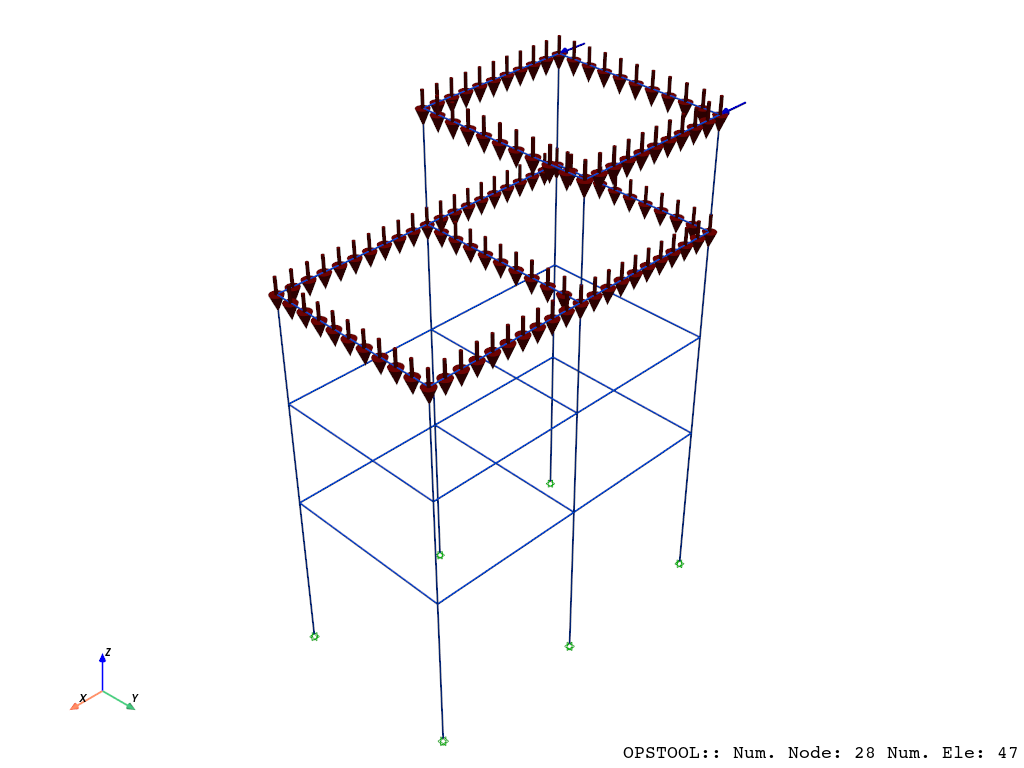

In [2]:
opst.load_ops_examples("Frame3D2")  # or your model code here

# add beam loads
ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)
ops.load(6, 10, 0.0, 0.0, 0.0, 0.0, 0.0)
ops.load(8, 10, 0.0, 0.0, 0.0, 0.0, 0.0)
for etag in [5, 6, 7, 8, 15, 16, 17, 18, 19, 20, 21]:
    ops.eleLoad("-ele", etag, "-type", "-beamUniform", 0.0, -10)

# plot
opst.vis.pyvista.set_plot_props(notebook=True)
fig = opst.vis.pyvista.plot_model(show_nodal_loads=True, show_ele_loads=True)
fig.show(jupyter_backend="static")

## Result Saving

In [3]:
ops.system("BandGeneral")
# Create the constraint handler, the transformation method
ops.constraints("Transformation")
# Create the DOF numberer, the reverse Cuthill-McKee algorithm
ops.numberer("RCM")
# Create the convergence test, the norm of the residual with a tolerance of
# 1e-12 and a max number of iterations of 10
ops.test("NormDispIncr", 1.0e-12, 10, 3)
# Create the solution algorithm, a Newton-Raphson algorithm
ops.algorithm("Newton")
# Create the integration scheme, the LoadControl scheme using steps of 0.1
ops.integrator("LoadControl", 0.1)
# Create the analysis object
ops.analysis("Static")

In [4]:
ODB = opst.post.CreateODB(odb_tag=1)
for i in range(10):
    ops.analyze(1)
    ODB.fetch_response_step()
ODB.save_response()

OPSTOOL ::  All responses data with odb_tag = 1 saved in _OPSTOOL_ODB/RespStepData-1.nc!

## Result Reading

In [5]:
all_resp = opst.post.get_element_responses(odb_tag=1, ele_type="Frame")

OPSTOOL ::  Loading response data from _OPSTOOL_ODB/RespStepData-1.nc ...

The result is an ``xarray DataSet`` object, and we can access the associated DataArray objects through ``.data_vars``.

In [6]:
all_resp.data_vars

Data variables:
    localForces          (time, eleTags, localDofs) float64 50kB ...
    basicForces          (time, eleTags, basicDofs) float64 25kB ...
    basicDeformations    (time, eleTags, basicDofs) float64 25kB ...
    plasticDeformation   (time, eleTags, basicDofs) float64 25kB ...
    sectionForces        (time, eleTags, secPoints, secDofs) float64 372kB ...
    sectionDeformations  (time, eleTags, secPoints, secDofs) float64 372kB ...
    sectionLocs          (time, eleTags, secPoints) float64 62kB ...

The ``variable names``, along with their ``dimensions`` and ``coordinates``, are displayed above.
The first four represent the resistance and deformation at both ends of the element, while the last three are quantities related to the cross-section.

In [7]:
all_resp["basicForces"]

<xarray.DataArray 'basicForces' (time: 11, eleTags: 47, basicDofs: 6)> Size: 25kB
[3102 values with dtype=float64]
Coordinates:
  * eleTags    (eleTags) int32 188B 1 2 3 4 5 6 7 8 ... 40 41 42 43 44 45 46 47
  * basicDofs  (basicDofs) <U3 72B 'N' 'MZ1' 'MZ2' 'MY1' 'MY2' 'T'
  * time       (time) float64 88B 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0

In [8]:
all_resp.attrs

{'localDofs': 'local coord system dofs at end 1 and end 2',
 'basicDofs': 'basic coord system dofs at end 1 and end 2',
 'secPoints': 'section points No.',
 'secDofs': 'section forces and deformations Dofs. Note that the section DOFs are only valid for <Elastic Section>, <Elastic Shear Section>, and <Fiber Section>. For <Aggregator Section>, you should carefully check the data, as it may not correspond directly to the DOFs.'}

### Section response

Sometimes we are more concerned with the response at the section level, which can be easily extracted.
For example, extracting section forces involves four dimensions: ``time (time)``, ``element IDs (eleTags)``, ``section locations (secLocs)``, and ``degrees of freedom (secDoFs)``.

In [9]:
sec_forces = all_resp["sectionForces"]
sec_forces

<xarray.DataArray 'sectionForces' (time: 11, eleTags: 47, secPoints: 15,
                                   secDofs: 6)> Size: 372kB
[46530 values with dtype=float64]
Coordinates:
  * eleTags    (eleTags) int32 188B 1 2 3 4 5 6 7 8 ... 40 41 42 43 44 45 46 47
  * secPoints  (secPoints) int32 60B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * secDofs    (secDofs) <U2 48B 'N' 'MZ' 'VY' 'MY' 'VZ' 'T'
  * time       (time) float64 88B 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0

In [10]:
sec_locs = all_resp["sectionLocs"].sel(eleTags=6, time=0).data
sec_locs

array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
       0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ])

We can select the response of multiple elements. 
``.isel(time=-1)`` is used to retrieve the data at the last time step, where ``.isel`` means indexing by position.

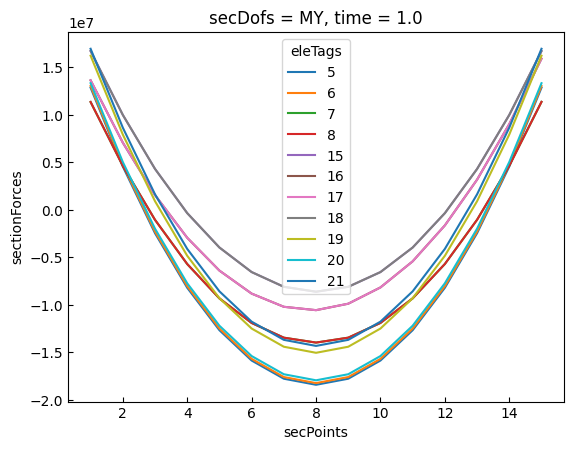

In [11]:
sec_forces_my = sec_forces.sel(
    eleTags=[5, 6, 7, 8, 15, 16, 17, 18, 19, 20, 21],
    secDofs="MY",
).isel(time=-1)
# sec_forces_my.coords["secPoints"] = sec_locs

# plot
sec_forces_my.plot.line(
    x="secPoints",
)
plt.show()

Here, we retrieve the moment about the local y-axis for element 6:

Note: ``.sel`` is the abbreviation for "select".

In [12]:
sec_forces_my = sec_forces.sel(eleTags=6, secDofs="MY")
sec_forces_my

<xarray.DataArray 'sectionForces' (time: 11, secPoints: 15)> Size: 1kB
[165 values with dtype=float64]
Coordinates:
    eleTags    int32 4B 6
  * secPoints  (secPoints) int32 60B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    secDofs    <U2 8B 'MY'
  * time       (time) float64 88B 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0

We can plot the moment at different section locations for various time steps.

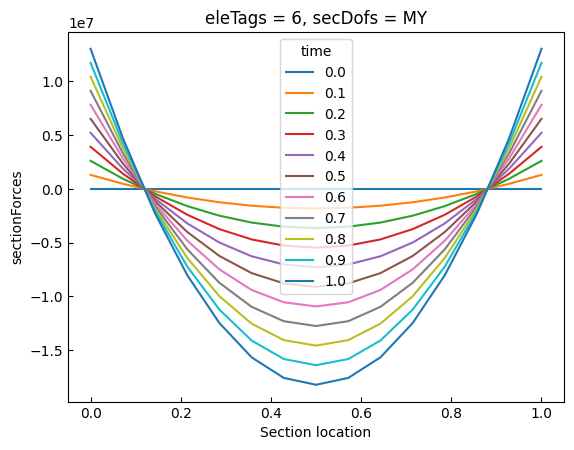

In [13]:
sec_forces_my.coords["secPoints"] = sec_locs
times = np.linspace(0, 1, 11)
sec_forces_my.coords["time"] = [f"{d:.1f}" for d in times]

# plot
sec_forces_my.plot.line(x="secPoints")
plt.xlabel("Section location")
plt.show()